# Purpose of this simulation

we wanted to check that with full matrix works with lasso regression?

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *
from weights_linear_regression import calc_R2_with_sim_C

# so that we write in latex
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')

# ideas

In [13]:
data_dump_folder = \
        '/home/aolab/sijia/data/figure3_lasso/'

ROUND_DECIMALS = 3


random_seed =2
n_neurons = 128

# clda setup 
rho = 0.5
batchlen = 100
feature_selection_method = "joint_convex"
encoder_change_mode = "shuffle_rows"
# encoder_change_mode = "change_to_zeros"

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

# feature_selection_method 
feature_selection_method = "full"
exp_conds = []

# uncomment out this to compare to the full feature selection method
# exp_conds_wo = [f'{feature_selection_method}_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_{encoder_change_mode}' ]
# exp_conds += exp_conds_wo




#smoothness_array =  np.arange(0.025, 0.15, 0.025)
smoothness_array = [0.05]
num_lags_array = [3]
num_of_features = 32 # specify how many features we want to use, or None


##### lasso
lasso_alphas = [10]
lasso_thresholds = [ 0, 1]
more_exp_conds = []
for lasso_alpha in lasso_alphas:
    for lasso_threshold in lasso_thresholds:
        more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')
exp_conds += more_exp_conds
        
##### last one is with the full feature selection
more_exp_conds = []
updater_type = "smooth_batch_with_full_feature"
for lasso_alpha in lasso_alphas:
    for lasso_threshold in lasso_thresholds:
        more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')

# add smooth batch with full batch
UPDATER_TYPE = "smooth_batch_with_full_feature"
if  UPDATER_TYPE != 'smooth_batch':
    for i, exp_cond in enumerate(more_exp_conds):
        more_exp_conds[i] = exp_cond + f'_{UPDATER_TYPE}'
        
exp_conds += more_exp_conds

# feature_selection_schemes = ['lasso threshold 0','lasso threshold 1', 'lasso threshold 2', 'lasso threshold 2.5',
#                              'lasso threshold 0 w/ full matrix','lasso w/ full matrix threshold 1', 'lasso w/ full matrix threshold 2', 'lasso w/ full matrix threshold 2.5']

feature_selection_schemes = ['lasso threshold 32',
                             'lasso threshold 64', 
                             'lasso w/ full matrix threshold 32 ',
                             'lasso w/ full matrix threshold 64']


print("the folder at which data is located:")
print(data_dump_folder)
for m,e in zip(feature_selection_schemes, exp_conds):print(m, ':', e)

the folder at which data is located:
/home/aolab/sijia/data/figure3_lasso/
lasso threshold 32 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_0_shuffle_rows
lasso threshold 64 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows
lasso w/ full matrix threshold 32  : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_0_shuffle_rows_smooth_batch_with_full_feature
lasso w/ full matrix threshold 64 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows_smooth_batch_with_full_feature


In [14]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 4 number of experiments


# Check feature selection strategies

## Plot selected features across feature selection methods

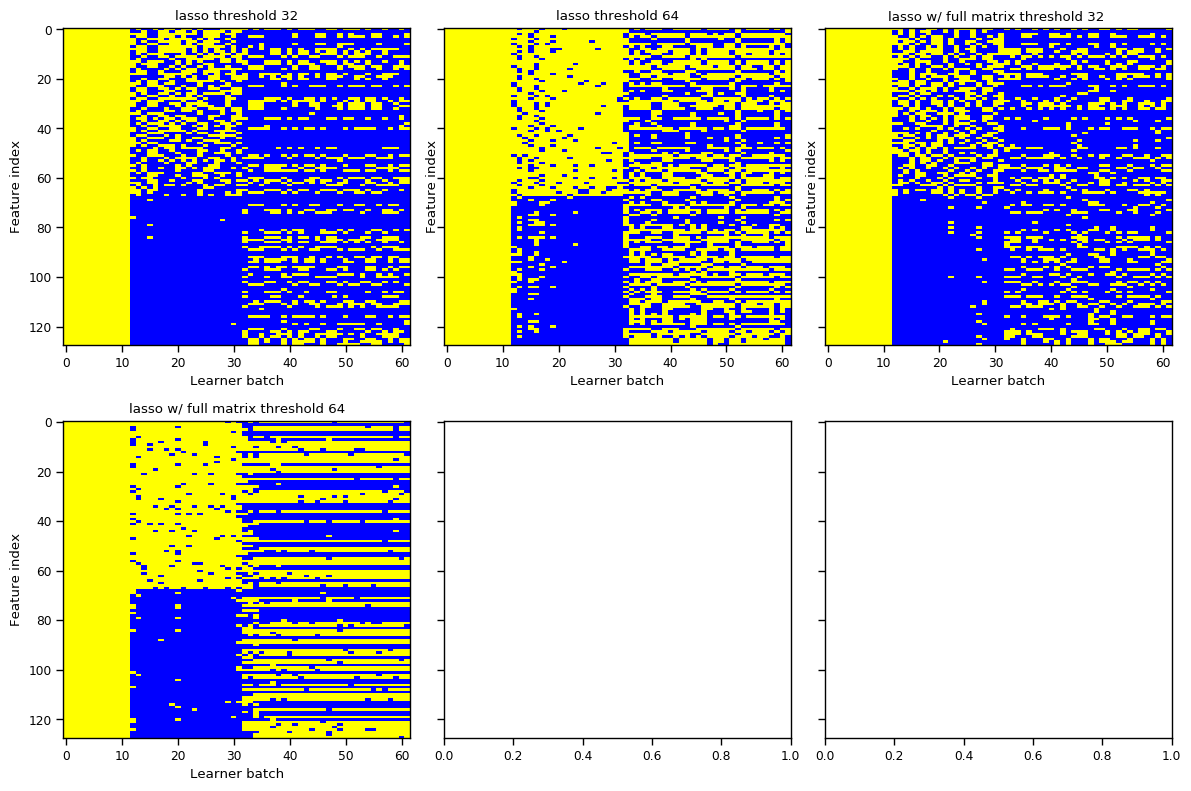

In [15]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 3, 
                                                    sharey = True,
                                                    figsize = (12, 8))

    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()



In [16]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)


In [17]:
print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")

print(smoothness_conds_by_batch.shape)

(4, 62, 128)
(4, 61)


/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/

(4, 61)

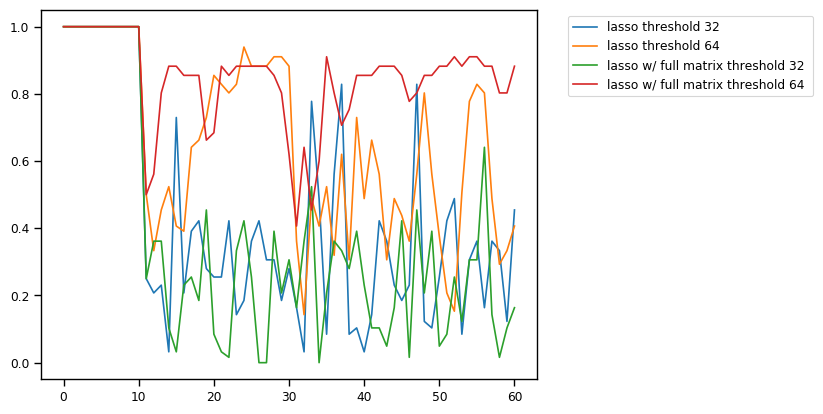

In [18]:
#sns.set_palette("Blues")

ax  = sns.lineplot(data = smoothness_conds_by_batch.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)
smoothness_conds_by_batch.shape

/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/

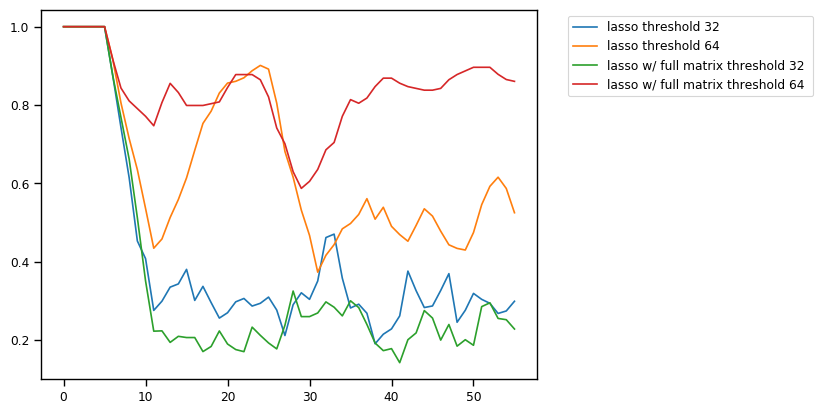

In [19]:


# Assuming smoothness_conds_by_batch is a numpy array with shape (n_batches, n_features)
window_size = 6
weights = np.ones(window_size) / window_size
smoothness_conds_by_batch_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=1,
                                                   arr=smoothness_conds_by_batch)

ax  = sns.lineplot(data = smoothness_conds_by_batch_ma.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)

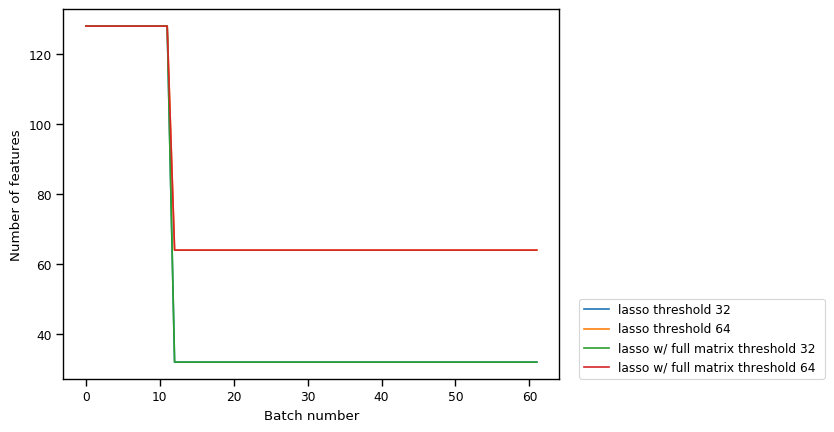

In [20]:
fig_num_features, ax_num_features = plt.subplots()

ax_num_features.plot(num_features_exp_by_batch.T)

ax_num_features.set_xlabel('Batch number')
ax_num_features.set_ylabel('Number of features')

ax_num_features.legend(feature_selection_schemes, loc=(1.04,0))

## calculate the relevance


In [21]:
from sklearn.metrics import r2_score

def calc_R2_with_sim_C( spike_counts_batch,intended_velocities, C_mat, active_set, 
                       remove_first_and_last_Batch = True, 
                       c_mat_remove_first_batch = True, 
                       select_only_vel_states = True,
                       select_features_with_active_set = False,
                       debug = True):
    
    
        # then we iterate through the batch sort of thing.
    NUM_LEARNER_BATCHES = intended_velocities.shape[0]
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
    
    if remove_first_and_last_Batch:
        active_set = active_set[1:-1, :]
    if c_mat_remove_first_batch:
        C_mat = C_mat[1:, :, : ]
        
    if select_only_vel_states:
        C_mat = C_mat[:,:,(X_VEL_STATE, Y_VEL_STATE,CONST_STATE)]
        
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
        

    
    R_2_over_batch = []
    
    for i in range(NUM_LEARNER_BATCHES):
        
        batch_vel =  intended_velocities[i,:,:]
        
        # check if we get the data from the list or the np.ndarray
        if type(spike_counts_batch) == list:
            batch_spike_counts = spike_counts_batch[i]
        else:
            batch_spike_counts = spike_counts_batch[i,:,:]
        
        #  we can only compare to what's being used in the calculation
        if select_features_with_active_set:
            if debug: print(batch_spike_counts.shape)
            batch_spike_counts = batch_spike_counts[active_set[i,:],:].T
        else:
            batch_spike_counts = batch_spike_counts[: ,:].T
        
        batch_c_mat = C_mat[i,:,:]
        
        selected_c_mat = batch_c_mat[active_set[i,:],:]
        

        estimated_spike_counts = selected_c_mat @ batch_vel
        
        score = r2_score(batch_spike_counts, estimated_spike_counts.T)
        
        R_2_over_batch.append(score)
        
    return R_2_over_batch

In [26]:

R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)
        print(intended_kin.shape)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    # #save  the results
    # R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

(60, 7, 100)
0
(60, 7, 100)
1
(60, 7, 100)
2
(60, 7, 100)
3


In [36]:
# apply moving average to the first axis
window_size = 6
weights = np.ones(window_size) / window_size
R_2_over_batches_all_exp_gap_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=0,
                                                   arr=R_2_over_batches_all_exp_gap)

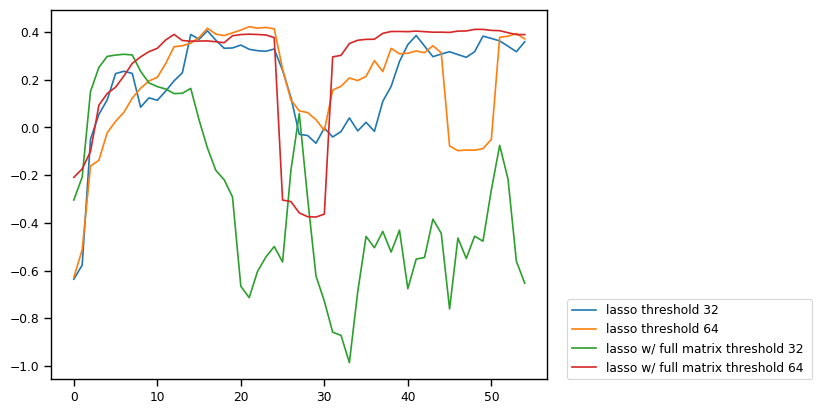

In [37]:
plt.plot(R_2_over_batches_all_exp_gap_ma)
plt.legend(feature_selection_schemes, loc=(1.04,0))



# Behaviour comparision

## count how many rewards

In [39]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

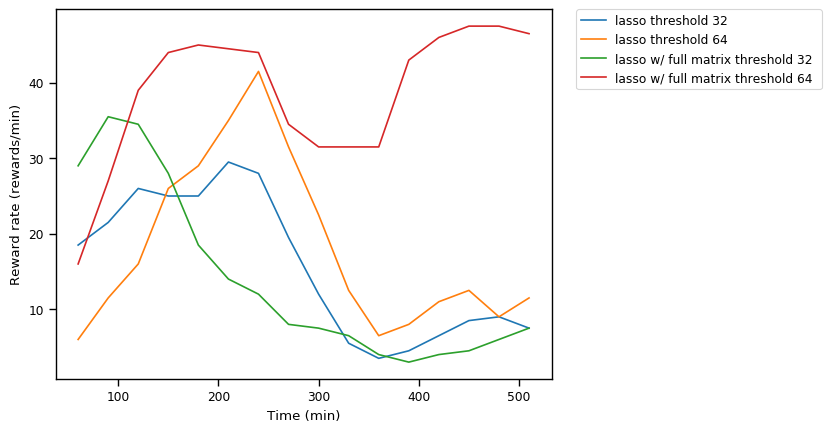

In [40]:
colors = ['blue', 'orange', 'red']

plt.plot(window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')
# put the legend outside of the figure
plt.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


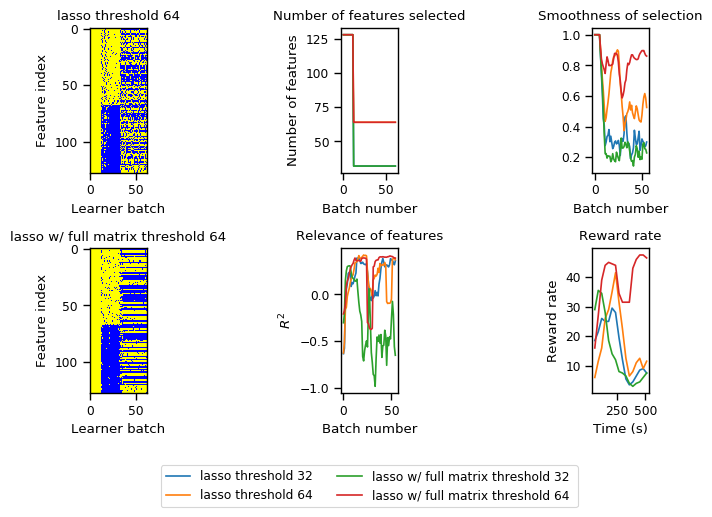

In [43]:
# let's make a summary plot
summary_figure, summary_axes = plt.subplots(2, 3, figsize = (6.5, 5.5))

# plot the feature selection results
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = summary_axes[0,0])
plot_feature_selection(exp_data_all[3]['feature_selection']['feat_set'], ax = summary_axes[1,0])
summary_axes[0,0].set_title(feature_selection_schemes[1])
summary_axes[1,0].set_title(feature_selection_schemes[3])


# number of features selected
summary_axes[0,1].plot(num_features_exp_by_batch.T)
summary_axes[0,1].set_xlabel('Batch number')
summary_axes[0,1].set_ylabel('Number of features')
summary_axes[0,1].set_title('Number of features selected')
# plot the relevance of the features

summary_axes[1,1].plot(R_2_over_batches_all_exp_gap_ma)
summary_axes[1,1].set_xlabel('Batch number')
summary_axes[1,1].set_ylabel(r'$R^2$')
summary_axes[1,1].set_title('Relevance of features')

# put the legend below the plot
summary_axes[1,1].legend(feature_selection_schemes, bbox_to_anchor=(0.5, -0.5), loc=9, borderaxespad=0., ncol = 2)


# plot the smoothness of the features
summary_axes[0,2].plot(smoothness_conds_by_batch_ma.T)
summary_axes[0,2].set_xlabel('Batch number')
summary_axes[0,2].set_title('Smoothness of selection')

# plot the reward rate
summary_axes[1,2].plot(window_time_stamps, reward_rate_all.T)
summary_axes[1,2].set_ylabel('Reward rate')
summary_axes[1,2].set_xlabel('Time (s)')
summary_axes[1,2].set_title('Reward rate')



# plot the reward rate
summary_figure.tight_layout()

In [157]:
summary_figure.savefig('encoder_change_summary_figure.png', bbox_inches='tight')

330 155 175
203 91 111


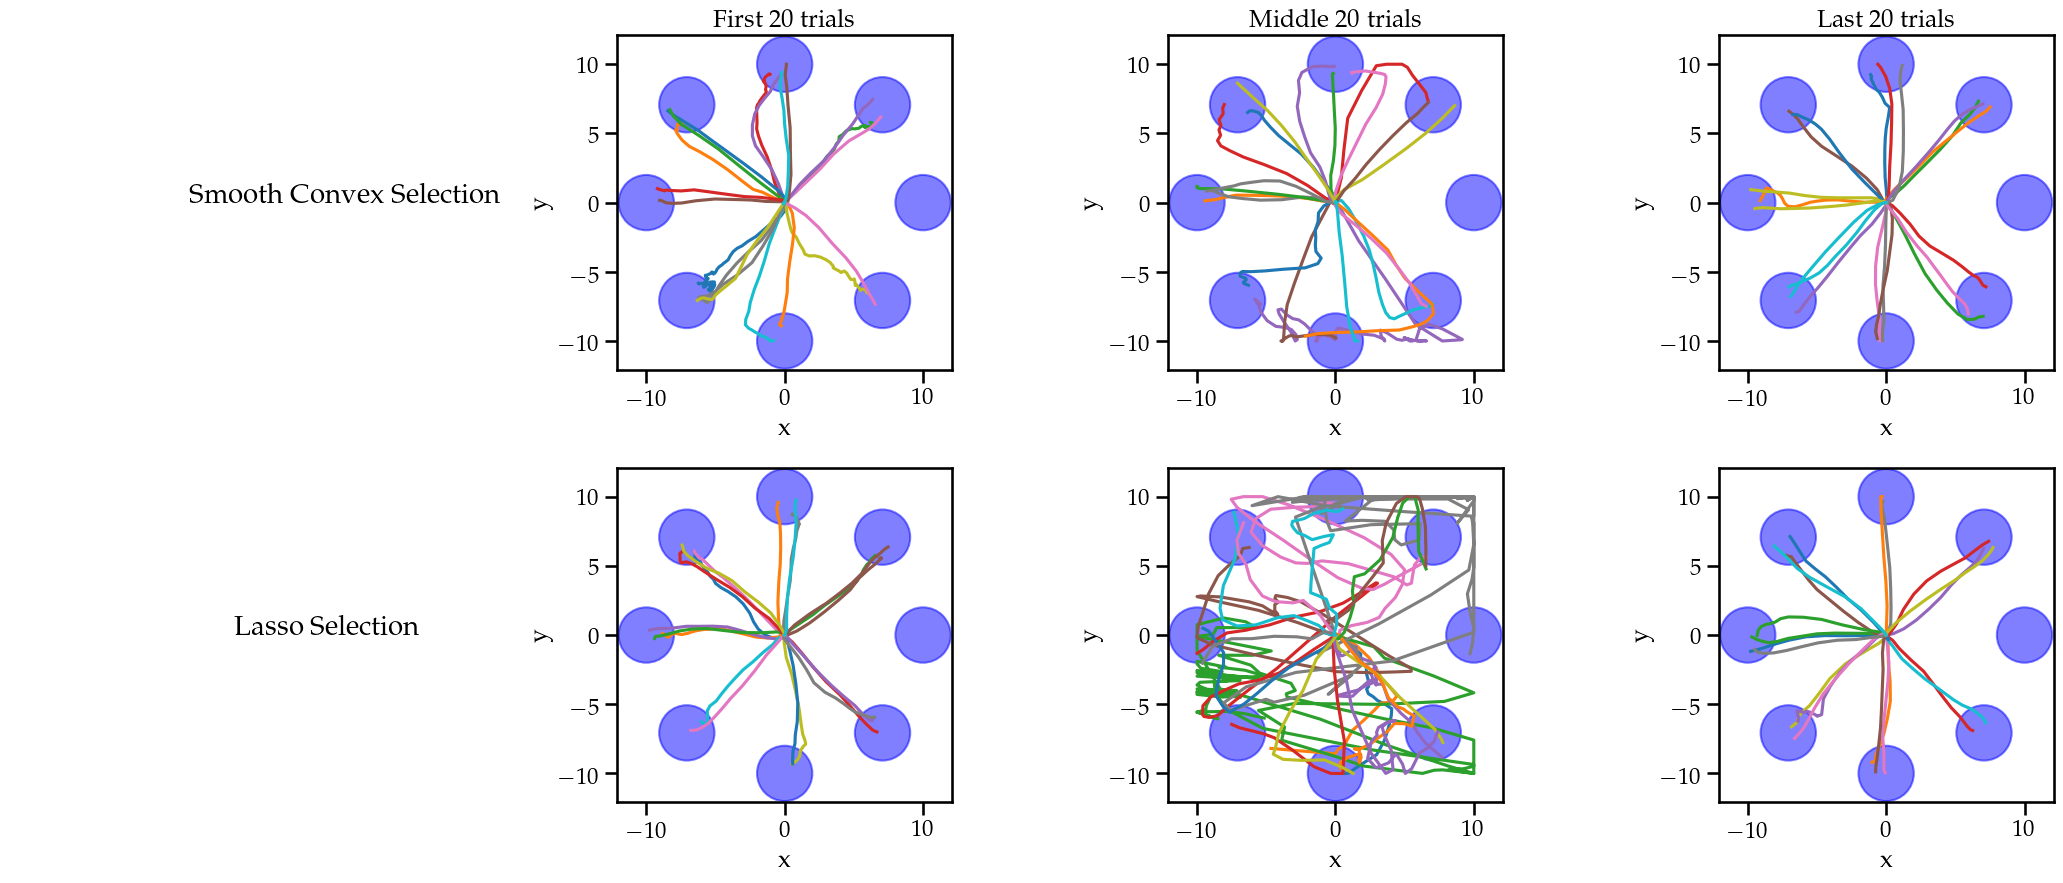

In [101]:
#cursor_trajectories_list = np.array(cursor_trajectories_list).reshape(2, -1)
fig_trajectory, ax_trajectory = plt.subplots(2, 4, figsize = (22, 9))

# calculate the first 20, middle 20, and last 20 trials 
number_of_lengths = 20

trial_lengths = np.array([len(c) for c in cursor_trajectories_list])
trial_periods = [((t // 2 - number_of_lengths // 2), (t // 2 + number_of_lengths // 2)) for t in trial_lengths]

for _ax, c in zip(ax_trajectory[:,1], cursor_trajectories_list):
    plot_cursor_trajectories(c[:number_of_lengths], exp_data_all[0], exp_metadata_all[0], 
                        ax = _ax)


for _ax, c, (t_start, t_stop) in zip(ax_trajectory[:,2], cursor_trajectories_list, trial_periods):
    print(len(c), t_start, t_stop)
    plot_cursor_trajectories(c[t_start: t_stop], exp_data_all[0], exp_metadata_all[0], ax=_ax)


for _ax, c in zip(ax_trajectory[:,3], cursor_trajectories_list):
    plot_cursor_trajectories(c[-number_of_lengths:], exp_data_all[0], exp_metadata_all[0], 
                            ax = _ax) 

fig_trajectory.tight_layout()
ax_trajectory[0,1].set_title(f'First {number_of_lengths} trials')
ax_trajectory[0,2].set_title(f'Middle {number_of_lengths} trials')
ax_trajectory[0,3].set_title(f'Last {number_of_lengths} trials')

ax_trajectory[0,0].axis('off')
ax_trajectory[1,0].axis('off')

ax_trajectory[0,0].annotate('Smooth Convex Selection', xy=(0.4, 0.5), fontsize = 20)
ax_trajectory[1,0].annotate('Lasso Selection', xy=(0.5, 0.5), fontsize = 20)
plt.show()

In [169]:
fig_trajectory.savefig('cursor_trajectories.pdf', bbox_inches='tight')

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

# Decoder matrix comparing w/ and w/o full matrix tracking

In [66]:
for k in exp_data_all[0]['feature_selection'].keys():
    print(k)

C_mat
K_mat
Q_diag
assist_level
batch_size
batch_time
change_sim_c_at_cycle
feat_set
feature_weights
fixed_noise_level
half_life
init_feat_set
n_starting_feats
n_states
new_sim_c
no_noise_neuron_ind
noise_mode
noise_neuron_ind
num_of_lags
number_of_features
objective_offset
past_batch_decay_factor
percent_noise
sim_C
smoothness_coef
sparsity_coef
threshold_selection
total_exp_time
train_high_SNR_time
transform_x_flag
transform_y_flag


(61, 128, 7)


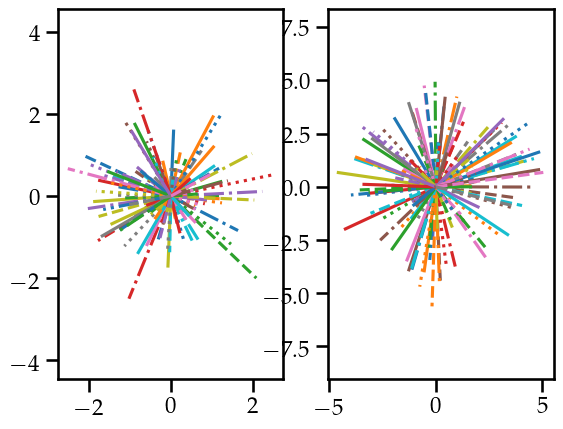

In [67]:
from afs_plotting import plot_prefered_directions

C_mat = exp_data_all[1]['feature_selection']['C_mat']

print(C_mat.shape)



fig, ax = plt.subplots(1,2)

plot_prefered_directions(C_mat[0], ax = ax[0])
plot_prefered_directions(C_mat[-1], ax = ax[1])

## Decoder compared to the encoder



In [105]:
exp_data_all[0].keys()

dict_keys(['bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])

In [61]:
from afs_files import load_clda_pickle_file, convert_to_list
clda_data_full = load_clda_pickle_file(data_dump_folder, exp_conds)

clda_dict_all = [convert_to_list(clda_data) for clda_data in clda_data_full]

for k in clda_dict_all[-1].keys():print(k)

kf.C
kf.Q
kf.C_xpose_Q_inv_C
kf.C_xpose_Q_inv
mFR
sdFR
rho
selected_decoder_features_flag
full_kf_C
full_kf_Q
intended_kin
spike_counts_batch
unselected_spike_counts_batch
active_feat_set


In [70]:
def extract_a_method(clda_dict_all_temp, *args):
    if type(clda_dict_all_temp) is dict:
        clda_dict_all_temp = [clda_dict_all_temp]
    
    return [[clda_dict[method_name] for clda_dict in clda_dict_all_temp] for method_name in args]


kf_C, kf_Q, kf_C_full, kf_Q_full = extract_a_method(clda_dict_all[-1], 
                                           'kf.C', 'kf.Q',
                                           'full_kf_C', 
                                           'full_kf_Q')

kf_C, kf_Q = np.array(kf_C), np.array(Kf_Q)
print(kf_C.shape, kf_Q.shape)
kf_C_full, kf_Q_full = np.squeeze(np.array(kf_C_full)), np.squeeze(np.array(kf_Q_full))
print(kf_C_full.shape, kf_Q_full.shape)

(1, 60) (1, 60)
(60, 128, 7) (60, 128, 128)


/tmp/ipykernel_4843/2892653998.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kf_C, kf_Q = np.array(kf_C), np.array(Kf_Q)


In [78]:
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix
feature_selection_data = exp_data_all[-1]['feature_selection']
enc_directions = feature_selection_data['sim_C']
dec_directions = kf_C_full

# dec_directions = np.moveaxis(dec_directions, 2,1)   
print(dec_directions.shape, enc_directions.shape)

angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                            enc_directions)

new_enc_directions = feature_selection_data['new_sim_c']
angles_hist_new = calc_cosine_to_target_matrix(dec_directions,
                                               new_enc_directions)

active_angles = np.mean(angles_hist, axis = 1)
new_active_angles = np.mean(angles_hist_new, axis = 1)

(60, 128, 7) (128, 7)


Text(0.5, 1.0, 'Mean encoder-decoder angle')

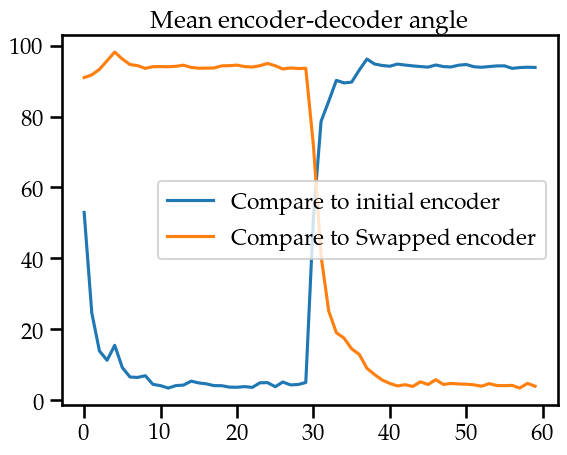

In [81]:
plt.plot(active_angles,label = 'Compare to initial encoder')
plt.plot(new_active_angles,label = 'Compare to Swapped encoder')
plt.legend()
plt.title('Mean encoder-decoder angle')

## batch update 

In [ ]:
exp_data_all

In [ ]:
len(exp_data_all)

In [17]:
import importlib
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

def train_C_mat_on_batch_data(intended_kin, spike_counts_batch):

    C_hat_list = list()
    
    num_times =  intended_kin.shape[0]
    
    for i  in range(num_times):

        k = intended_kin[i, :,:]
        s = spike_counts_batch[i,:,:]

        C,Q = KalmanFilter.MLE_obs_model(k, s, include_offset=False, drives_obs=[3,5])

        C_hat_list.append(C)



    C_hat_list = np.array(C_hat_list)
    
    return C_hat_list
    

In [ ]:
c_hat_angles = calc_cosine_to_target_matrix(c_hat_list)

## compare to lasso regularization

In [19]:
from sklearn.linear_model import Lasso, LinearRegression

alpha = 10
max_iteration = 10000

lasso_model = Lasso(alpha, max_iter = max_iteration)
linear_reg_model = LinearRegression()

In [20]:
drive_obs = [3,5]

intended_kin_one_batch = intended_kin[0,drive_obs,:]
spike_counts_one_batch = spike_counts_batch[0,:,:]

lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T )

Lasso(alpha=10, max_iter=10000)

In [21]:
linear_reg_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)

LinearRegression()

In [22]:
# get a series of alphas 

alpha_series = [0, 1, 10, 100] #get a series of alphas

alpha_weights_scan = []

for a in alpha_series:
    lasso_model.set_params(alpha = a)
    lasso_model.fit(intended_kin_one_batch.T, spike_counts_one_batch.T)
    
    alpha_weights_scan.append(lasso_model.coef_.copy())
    
    print(f'finished alpha = {a}')

alpha_weights = np.array(alpha_weights_scan)

finished alpha = 0
finished alpha = 1
finished alpha = 10
finished alpha = 100


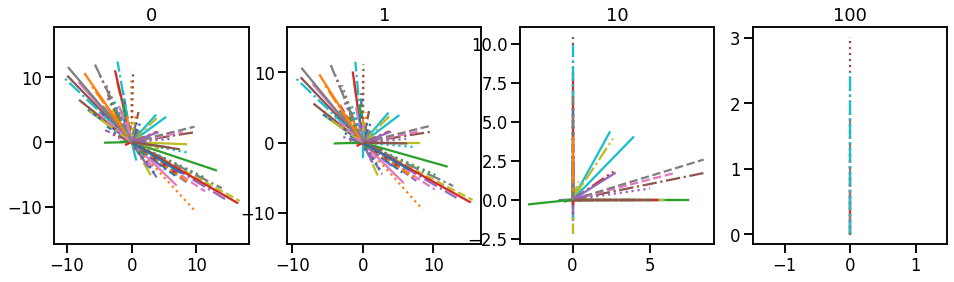

In [23]:
from afs_plotting import plot_prefered_directions

fig, ax = plt.subplots(1, len(alpha_series), figsize = (4 * len(alpha_series), 4))

for a,w,ax_i in zip(alpha_series, alpha_weights_scan, ax):
    plot_prefered_directions(w, ax = ax_i)
    ax_i.set_title(a)


In [24]:
alpha_weights_norm = np.linalg.norm(alpha_weights, axis = 2)

Text(0, 0.5, 'Weight norm')

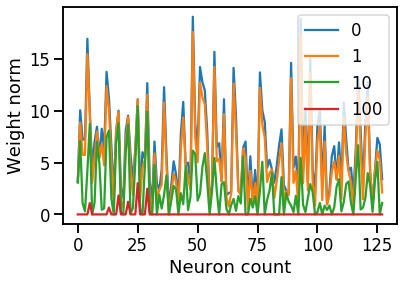

In [25]:
plt.plot(alpha_weights_norm.T)
plt.legend(alpha_series)
plt.xlabel('Neuron count')
plt.ylabel('Weight norm')

In [26]:
# we can then look at lasso path to figure out the smooth coefficients 

from sklearn.linear_model import lasso_path 

eps = 5e-3  # the smaller it is the longer is the path
print("Computing regularization path using the lasso...")
X = intended_kin_one_batch.T
y = spike_counts_one_batch.T
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print(alphas_lasso.shape,min(alphas_lasso), max(alphas_lasso))
print('shape of coefs_lasso', coefs_lasso.shape)

Computing regularization path using the lasso...
(100,) 55.02534879416641 11005.069758833279
shape of coefs_lasso (128, 2, 100)


(100,)

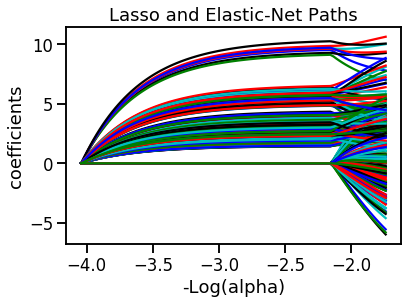

In [27]:

from itertools import cycle

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l.T, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")

neg_log_alphas_lasso.shape

(128, 100)


(100,)

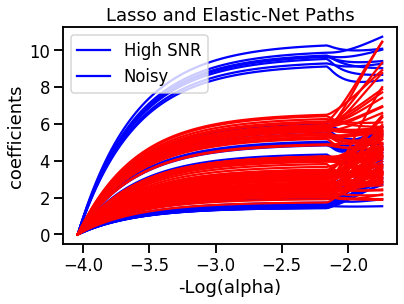

In [28]:
from numpy.linalg import norm

coefs_lasso_norm = norm(coefs_lasso, axis = 1)
print(coefs_lasso_norm.shape)



from itertools import cycle


num_high_snr = 32
num_noise = 96

plt.figure(1)
colors = ['b'] * num_high_snr + ['r'] * num_noise
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for l1_coef, c in zip(coefs_lasso_norm, colors):

    l1 = plt.plot(neg_log_alphas_lasso, l1_coef, c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.axis("tight")
plt.legend(['High SNR', 'Noisy'])
neg_log_alphas_lasso.shape

there are two issue

In [39]:
lasso_hist = feature_selection_data['lasso_hist']

print(lasso_hist.shape)

(240, 2, 128)


##  examine the lasso_hist coefficients.
the main problem is that it does not converge on the fly
it does not converge,  becasue we did not use the right indices to train. 
this can still happen in real time.

this highlights the issue in real time,  we just cannot randomly trained a lasso regression. 


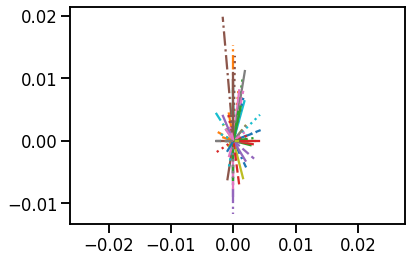

In [41]:
num_batch = 0
plot_prefered_directions(lasso_hist[num_batch, :, :].T)

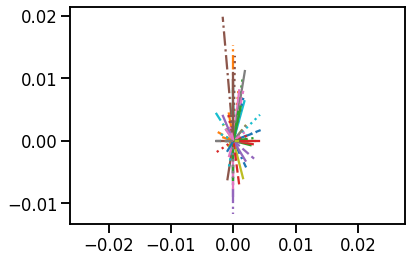

In [43]:
num = -1
plot_prefered_directions(lasso_hist[num_batch,:,:].T)

a quick comparision between the two shows that the observation matrix does not change. 
which basically makes sense, in the sense that 

## looking at K matrix

In [ ]:
NUM_EXP = 3
GLOBAL_FIGURE_VERTICAL_SIZE  = 4

figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))
exp_data_all_reshaped = exp_data_all.reshape(3, N_RUNS)


#compare the K matrix before the exp
for i in range(NUM_EXP):
    K_mat = exp_data_all_reshaped[0,i]['feature_selection']['K_mat']
    K = K_mat[1].T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i], plot_states = [0,2])
    axes_k_matrix[0, i].set_title(exp_conds[i])

#compare to the matrix after the exp
for i in range(3):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    
    K = K_mat[-1].T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i], plot_states = [0,2])
    axes_k_matrix[1,i].set_title(exp_conds[i])
figure_k_matrix.tight_layout()

In [ ]:



def plot_state_bar(K:np.ndarray, ax =  None, fig = fig, state_names = None):
    """
    K [np.array]: a state variable that records the state
    """
    
    num_state, num_var = K.shape
    
    if num_state >= num_var: print(f'Number of states {num_state} is greater than the {num_var} \n is this intended?')
        
    if ax is None: fig, ax = plt.subplots(2, 3, figsize = (12, 8),sharex =  True)
        
    var_pos = np.arange(num_var)
    
    for i in range(3):
        ax[0, i].bar(var_pos, K[i,:])
        ax[1,i].bar(var_pos, K[i + 3,:])
        
        
        
    fig.tight_layout()
    
    return ax


fig, ax = plt.subplots(2,3, figsize = (12,8))


for i in range(len(exp_data_all)):
    K_mat = exp_data_all[i]['feature_selection']['K_mat']
    K = K_mat[-1]

    plot_state_bar(abs(K), ax = ax, fig = fig)

In [259]:
active_feat_set = feature_selection_data['feat_set']
active_feat_set_last = active_feat_set[0]
active_angles_list = list()

least_num_updates = 180

for i,e in enumerate(exp_conds):
    feature_selection_data = exp_data_all[i]['feature_selection']
    enc_directions = feature_selection_data['sim_C']
    dec_directions = feature_selection_data['K_mat']

    dec_directions = np.moveaxis(dec_directions, 2,1)   
    

    angles_hist = calc_cosine_to_target_matrix(dec_directions,
                                               enc_directions)
    
    active_angles = np.mean(angles_hist[:, no_noise_neuron_ind], axis = 1)
    

    active_angles_list.append(active_angles[:least_num_updates])


/home/sijia66/miniconda3/envs/afs/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


IndexError: list index out of range

In [ ]:

active_angles_list = np.array(active_angles_list)
active_angles_list = active_angles_list.reshape((3,N_RUNS,-1))

active_angles_mean = np.mean(active_angles_list, axis = 1)
active_angles_std = np.std(active_angles_list, axis = 1)

colors = ['blue', 'orange', 'red'] 

print(active_angles_mean.shape)

fig_C, ax_C = plt.subplots()



for i,c in enumerate(colors):

    plt.plot(active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)


plt.xlabel('Learner batch number')
plt.ylabel('Encoder-decoder error (deg.)')
plt.legend(['Full set', 'Iter add.', 'Subset'])

In [ ]:


fig_C, ax_C = plt.subplots()


colors = ['blue', 'orange'] 

batch_num = np.arange(least_num_updates) * 10

print(active_angles_mean.shape)

for i,c in enumerate(colors):

    plt.plot(batch_num, active_angles_mean[i,:].T, color = c, linewidth = 3)
    plt.fill_between(batch_num,
                    active_angles_mean[i,:] + active_angles_std[i,:],
                    active_angles_mean[i,:] - active_angles_std[i,:],
                    alpha = 0.3, color = c)

plt.title('Initial training on subset enables faster decoder convergence')
plt.xlabel('Training time (s)')
plt.ylabel('Encoder-decoder error (deg.)', fontsize = 14)
plt.legend(['Full set', 'Iter add.'])

In [ ]:
# examine the features after the first update.

def find_K_gain(index:int, update_period: float, fps = 60):
    """
    find the latest Kalman gain
    """
    update_frame_count = int(update_period * fps)
    
    return int(index // update_frame_count)
    
def test_find_K_gain():
    
    assert 0 == find_K_gain(598, 10, 60)
    assert 1 == find_K_gain(1198, 10, 60)

test_find_K_gain()

In [ ]:
update_time = 600

spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']
spike_counts = np.squeeze(spike_counts)

spike_counts_single_time = spike_counts[update_time, :]

target_state  = exp_data_all[0]['bmi3d_task']['target_state']
target_state_time = target_state[update_time, :]


num_K = find_K_gain(update_time, update_period = 10)
K_mat_time = K_mat[num_K]

feature_state_update = K_mat_time @  np.diag(spike_counts_single_time)


target_state_time_rep = np.tile(target_state_time, len(spike_counts_single_time))


useful_update = feature_state_update * target_state_time_rep
useful_update = np.sum(useful_update, axis = 0)


plt.plot(useful_update)


In [ ]:
intended_kin = exp_data_all[0]['bmi3d_clda']['intended_kin']

spike_counts_batch = exp_data_all[0]['bmi3d_clda']['spike_counts_batch']
spike_counts_batch =  np.swapaxes(spike_counts_batch, 2, 1)

intended_kin = np.swapaxes(intended_kin, 2, 1)

spike_counts_batch.shape

In [ ]:
print(intended_kin.shape)

intended_kin_one = intended_kin[1, 1, :]
print(intended_kin_one)

## Q mat

In [ ]:
feature_selection_data.keys()

In [ ]:
fig_Q, axes_Q = plt.subplots(1,2, sharey = True)

num_noises = 1

from afs_plotting import get_cmap
import matplotlib as mpl

cmap_q = get_cmap(num_noises)

cmap_q_1 = get_cmap(num_noises, mpl.cm.Oranges)

cmap_q_2 = get_cmap(num_noises, mpl.cm.Reds)

for i in range(num_noises):
    
    for j in range(3):


        Q_list = np.array(exp_data_all[j]["feature_selection"]['Q_diag'])



        Q_diag_no_noise = np.mean(Q_list[:, no_noise_neuron_ind], axis = 1)

        Q_diag_noise = np.mean(Q_list[:, noise_neuron_ind], axis = 1)



        axes_Q[0].plot(Q_diag_noise)

        axes_Q[1].plot(Q_diag_no_noise)

    

axes_Q[0].set_xlabel('Time (s)')

axes_Q[1].set_xlabel('Time (s)')



axes_Q[0].set_title('Low SNR neurons')

axes_Q[1].set_title('High SNR neurons')



# Feature analysis

In [ ]:
decoder_state = exp_data_all[0]['bmi3d_task']['decoder_state']
target_state = exp_data_all[0]['bmi3d_task']['target_state']
spike_counts = exp_data_all[0]['bmi3d_task']['spike_counts']


print(decoder_state.shape)
print(target_state.shape)
print(spike_counts.shape)

spike_counts = exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['bmi3d_task'].dtype

In [ ]:
exp_data_all[0]['feature_selection']['K_mat'].shape

In [ ]:
exp_data_all[0]['bmi3d_task']['update_bmi']

In [ ]:
np.argwhere((exp_data_all[0]['bmi3d_task']['update_bmi']))

## examine used C mat

In [ ]:
GLOBAL_FIGURE_VERTICAL_SIZE  =  10

fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list

for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C = enc_directions)


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
#axes_compr_means.set_title('Means of the high SNR weight trajectory')